## Lybraries Import

In [1]:
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster.elbow import KElbowVisualizer
from sklearn.mixture import GaussianMixture
from IPython.display import YouTubeVideo
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier
from scipy.cluster.hierarchy import dendrogram

import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView

## 1.Functions

In [2]:
def number_clusters(df,cluster_model):
    metrics=['silhouette','distortion','calinski_harabasz']
    model=cluster_model
    for score in metrics:
        plt.figure()
        plt.ylabel(score)
        plt.xlabel('Number of clusters')
        Visualizer=KElbowVisualizer(model,metric=score).fit(df)
        plt.show

In [3]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

In [4]:
def gmm_config(data,limit_nrcomponents):
    bic_values =[]
    aic_values =[]
    types_covariance=['full','diag','spherical']
    for i in types_covariance:
        n_components = np.arange(1, limit_nrcomponents)
        models = [GaussianMixture(n, covariance_type=i, n_init=10, random_state=1).fit(data)
                  for n in n_components]
        bic_values.append([m.bic(data) for m in models])
        aic_values.append([m.aic(data) for m in models])
    #barplot for BIC
    bic=plt.figure(1)
    X = np.arange(1,limit_nrcomponents)
    plt.bar(X + 0.00, bic_values[0], label='full' ,color = 'b', width = 0.3)
    plt.bar(X + 0.25, bic_values[1], label='diag',color = 'g', width = 0.3)
    plt.bar(X + 0.50, bic_values[2], label='spherical',color = 'r', width = 0.3)
    plt.xlabel('number of components')
    plt.ylabel('BIC')
    plt.legend(loc='best')
   #barplot for AIC
    aic=plt.figure(2)
    X = np.arange(1,limit_nrcomponents)
    plt.bar(X + 0.00, aic_values[0], label='full' ,color = 'b', width = 0.3)
    plt.bar(X + 0.25, aic_values[1], label='diag',color = 'g', width = 0.3)
    plt.bar(X + 0.50, aic_values[2], label='spherical',color = 'r', width = 0.3)
    plt.xlabel('number of components')
    plt.ylabel('AIC')
    plt.legend(loc='best')
    bic.show
    aic.show

In [5]:
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """This function computes the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt. 
    
    Parameters:
    df (DataFrame): Dataset to apply clustering
    link_method (str): either "ward", "complete", "average", "single"
    max_nclus (int): maximum number of clusters to compare the methods
    min_nclus (int): minimum number of clusters to compare the methods. Defaults to 1.
    dist (str): distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".
    
    Returns:
    ndarray: R2 values for the range of cluster solutions
    """
    def get_ss(df):
        ss = np.sum(df.var() * (df.count() - 1))
        return ss  # return sum of sum of squares of each df variable
    
    sst = get_ss(df)  # get total sum of squares
    
    r2 = []  # where we will store the R2 metrics for each cluster solution
    
    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        cluster = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link_method)
        hclabels = cluster.fit_predict(df) #get cluster labels
        df_concat = pd.concat((df, pd.Series(hclabels, name='labels')), axis=1)  # concat df with labels
        ssw_labels = df_concat.groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels
        ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
        r2.append(ssb / sst)  # save the R2 of the given cluster solution
        
    return np.array(r2)

In [6]:
#on 'type_covariance'-you have to insert with '', for example 'full'
def gmm_components(data,type_covariance,min_components,max_components):
    # Selecting number of components based on AIC and BIC
    n_components = np.arange(min_components,max_components)
    models = [GaussianMixture(n, covariance_type=type_covariance, n_init=10, random_state=1).fit(data)
              for n in n_components]

    bic_values = [m.bic(data) for m in models]
    aic_values = [m.aic(data) for m in models]
    plt.plot(n_components, bic_values, label='BIC')
    plt.plot(n_components, aic_values, label='AIC')
    plt.legend(loc='best')
    plt.xlabel('n_components')
    plt.xticks(n_components)
    plt.show()

# 2.Load the Perspective Dataset

In [7]:
normalized_df = pd.read_csv(r'C:\Users\gonca\Documents\BC1_GroupS\data\Cleaned_data.csv') 

In [8]:
perspective = normalized_df[['Age','Edu','Income','Kidhome','Teenhome']]
perspective.head()

Age       Edu    Income   Kidhome  Teenhome
0  0.084213  0.492809  0.055831 -0.229303 -0.296554
1  0.260030  0.093857  0.207936 -0.132845 -0.171806
2 -0.064435 -0.071185 -0.056779  0.151771  0.117353
3 -0.052335 -0.143322 -0.075243 -0.194696  0.236278
4  0.049439  0.369257  0.027139 -0.171815 -0.222205

# 4.K Means 

### 4.1.K-elbow plots

C:\Users\gonca\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\gonca\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\gonca\anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
findfont: score(<Font 'STIXGeneral' (STIXGeneral

findfont: score(<Font 'Goudy Stout' (GOUDYSTO.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Arial' (ariali.ttf) italic normal 400 normal>) = 1.05
findfont: score(<Font 'Tw Cen MT Condensed' (TCCB____.TTF) normal normal 700 condensed>) = 10.535
findfont: score(<Font 'Tw Cen MT' (TCM_____.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Cambria' (cambriab.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Sitka Small' (SitkaI.ttc) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Bodoni MT' (BOD_R.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Perpetua' (PERBI___.TTF) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Yu Gothic' (YuGothR.ttc) normal normal regular normal>) = 10.05
findfont: score(<Font 'Arial' (ARIALNI.TTF) italic normal 400 condensed>) = 1.25
findfont: score(<Font 'SimSun-ExtB' (simsunb.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Courier New' (cour.ttf) normal normal 400 norma

findfont: score(<Font 'Lucida Fax' (LFAXI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Yu Gothic' (YuGothM.ttc) normal normal medium normal>) = 10.145
findfont: score(<Font 'Papyrus' (PAPYRUS.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'MS Gothic' (msgothic.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Lucida Sans Typewriter' (LTYPEBO.TTF) oblique normal 700 normal>) = 11.335
findfont: score(<Font 'Franklin Gothic Heavy' (FRAHVIT.TTF) italic normal heavy normal>) = 11.43
findfont: score(<Font 'Calibri' (calibrili.ttf) italic normal light normal>) = 11.24
findfont: score(<Font 'Vladimir Script' (VLADIMIR.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Lucida Fax' (LFAXDI.TTF) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Castellar' (CASTELAR.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Bernard MT Condensed' (BERNHC.TTF) normal normal 400 condensed>) = 10.25
findfont: score(<Font 'Malgun Go

findfont: score(<Font 'High Tower Text' (HTOWERT.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Constantia' (constani.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Niagara Engraved' (NIAGENG.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Eras Bold ITC' (ERASBD.TTF) normal normal bold normal>) = 10.335
findfont: score(<Font 'Lucida Sans Typewriter' (LTYPE.TTF) normal normal regular normal>) = 10.05
findfont: score(<Font 'Wingdings 3' (WINGDNG3.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Agency FB' (AGENCYB.TTF) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Franklin Gothic Medium Cond' (FRAMDCN.TTF) normal normal medium condensed>) = 10.344999999999999
findfont: score(<Font 'Century Schoolbook' (SCHLBKB.TTF) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Gloucester MT Extra Condensed' (GLECB.TTF) normal normal 400 condensed>) = 10.25
findfont: score(<Font 'Yu Gothic' (YuGothB.ttc) normal normal 7

findfont: score(<Font 'Gill Sans Ultra Bold' (GILSANUB.TTF) normal normal bold normal>) = 10.335
findfont: score(<Font 'Arial Rounded MT Bold' (ARLRDBD.TTF) normal normal bold normal>) = 10.335
findfont: score(<Font 'SimSun' (simsun.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Bauhaus 93' (BAUHS93.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Jokerman' (JOKERMAN.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Javanese Text' (javatext.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Rockwell' (ROCKB.TTF) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Gill Sans MT' (GILI____.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Lucida Fax' (LFAX.TTF) normal normal regular normal>) = 10.05
findfont: score(<Font 'Playbill' (PLAYBILL.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Lucida Sans' (LSANSI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Leelawadee' (LEELAWAD.TTF) no

findfont: score(<Font 'Microsoft Tai Le' (taile.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Courier New' (courbd.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Microsoft New Tai Lue' (ntailub.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Yu Gothic' (YuGothB.ttc) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Palatino Linotype' (palab.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Gill Sans MT Ext Condensed Bold' (GLSNECB.TTF) normal normal bold condensed>) = 10.535
findfont: score(<Font 'Bell MT' (BELL.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Pristina' (PRISTINA.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Niagara Engraved' (NIAGENG.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Arial' (ARIALNB.TTF) normal normal 700 condensed>) = 0.5349999999999999
findfont: score(<Font 'Verdana' (verdana.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Fon

findfont: score(<Font 'Verdana' (verdanaz.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Copperplate Gothic Light' (COPRGTL.TTF) normal normal light normal>) = 10.24
findfont: score(<Font 'Times New Roman' (timesbd.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Corbel' (corbelz.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Dubai' (DUBAI-BOLD.TTF) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Comic Sans MS' (comicz.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Microsoft Uighur' (MSUIGHUR.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Calibri' (calibri.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'High Tower Text' (HTOWERTI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Segoe Print' (segoepr.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Bodoni MT' (BOD_I.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Old English Text MT' (OLD

findfont: score(<Font 'Consolas' (consolab.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Rockwell Condensed' (ROCC____.TTF) normal normal 400 condensed>) = 10.25
findfont: score(<Font 'Gigi' (GIGI.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Lucida Sans Typewriter' (LTYPEO.TTF) oblique normal 400 normal>) = 11.05
findfont: score(<Font 'Gill Sans MT' (GIL_____.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'MingLiU-ExtB' (mingliub.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Rockwell' (ROCKB.TTF) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Lucida Sans Typewriter' (LTYPEBO.TTF) oblique normal 700 normal>) = 11.335
findfont: score(<Font 'Franklin Gothic Heavy' (FRAHVIT.TTF) italic normal heavy normal>) = 11.43
findfont: score(<Font 'Microsoft JhengHei' (msjhbd.ttc) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Lucida Bright' (LBRITE.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font

findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal regular normal>) = 10.05
findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal regular normal>) = 10.05
findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal regular normal>) = 10.05
findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 11.05
findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal regular normal>) = 10.05
findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol

findfont: score(<Font 'Dubai' (DUBAI-BOLD.TTF) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Tahoma' (tahomabd.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Script MT Bold' (SCRIPTBL.TTF) normal normal bold normal>) = 10.335
findfont: score(<Font 'SimSun' (simsun.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Segoe UI' (segoeuil.ttf) normal normal light normal>) = 10.24
findfont: score(<Font 'Lucida Bright' (LBRITED.TTF) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Myanmar Text' (mmrtextb.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Yu Gothic' (YuGothL.ttc) normal normal light normal>) = 10.24
findfont: score(<Font 'Calisto MT' (CALISTB.TTF) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Mistral' (MISTRAL.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Cambria' (cambria.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Showcard Gothic' (SHOWG.TTF) normal normal 400 no

findfont: score(<Font 'Consolas' (consolaz.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Mongolian Baiti' (monbaiti.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Book Antiqua' (BKANT.TTF) normal normal book normal>) = 10.05
findfont: score(<Font 'Georgia' (georgiab.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Elephant' (ELEPHNTI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Snap ITC' (SNAP____.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Microsoft PhagsPa' (phagspa.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Lucida Bright' (LBRITEDI.TTF) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Microsoft JhengHei' (msjh.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Magneto' (MAGNETOB.TTF) normal normal 700 normal>) = 10.335
findfont: score(<Font 'SimSun-ExtB' (simsunb.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Bodoni MT' (BOD_CI.TTF) italic n

findfont: score(<Font 'Constantia' (constan.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Comic Sans MS' (comic.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Palatino Linotype' (palai.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Nirmala UI' (Nirmala.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Mongolian Baiti' (monbaiti.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Perpetua Titling MT' (PERTILI.TTF) normal normal light normal>) = 10.24
findfont: score(<Font 'Lucida Fax' (LFAX.TTF) normal normal regular normal>) = 10.05
findfont: score(<Font 'Gill Sans MT Ext Condensed Bold' (GLSNECB.TTF) normal normal bold condensed>) = 10.535
findfont: score(<Font 'Berlin Sans FB' (BRLNSR.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Palatino Linotype' (palab.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Bookman Old Style' (BOOKOSB.TTF) normal normal 700 normal>) = 10.335
findfont:

findfont: score(<Font 'Old English Text MT' (OLDENGL.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Microsoft PhagsPa' (phagspa.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Tempus Sans ITC' (TEMPSITC.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Wide Latin' (LATINWD.TTF) normal normal 400 expanded>) = 10.25
findfont: score(<Font 'Candara' (Candara.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Malgun Gothic' (malgun.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Century Gothic' (GOTHICB.TTF) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Microsoft YaHei' (msyh.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Stencil' (STENCIL.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Calisto MT' (CALISTI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Pristina' (PRISTINA.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Yu Gothic' (YuGothM.ttc) no

findfont: score(<Font 'Mistral' (MISTRAL.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Niagara Solid' (NIAGSOL.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Calibri' (calibrib.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Bell MT' (BELLB.TTF) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Garamond' (GARA.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Microsoft JhengHei' (msjh.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Georgia' (georgiai.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Century' (CENTURY.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Segoe UI' (segoeui.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Bodoni MT' (BOD_CBI.TTF) italic normal 700 condensed>) = 11.535
findfont: score(<Font 'Symbol' (symbol.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Dubai' (DUBAI-MEDIUM.TTF) normal normal medium normal>) = 10.145
fi

findfont: score(<Font 'MS Reference Specialty' (REFSPCL.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Bodoni MT' (BOD_CR.TTF) normal normal 400 condensed>) = 10.25
findfont: score(<Font 'Montserrat' (Montserrat-Medium.ttf) normal normal medium normal>) = 10.145
findfont: score(<Font 'Bodoni MT' (BOD_PSTC.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Brush Script MT' (BRUSHSCI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Century Gothic' (GOTHICB.TTF) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Lucida Bright' (LBRITEI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Ink Free' (Inkfree.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Constantia' (constanz.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Perpetua' (PERI____.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Footlight MT Light' (FTLTLT.TTF) normal normal light normal>) = 10.24
findfont: score(<Font 'Tw C

findfont: score(<Font 'Stencil' (STENCIL.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Trebuchet MS' (trebucit.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Microsoft PhagsPa' (phagspab.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Segoe UI' (segoeui.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Arial' (arial.ttf) normal normal 400 normal>) = 0.05
findfont: score(<Font 'Segoe UI' (seguisb.ttf) normal normal semibold normal>) = 10.24
findfont: score(<Font 'Segoe UI' (segoeuisl.ttf) normal normal light normal>) = 10.24
findfont: score(<Font 'Forte' (FORTE.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Gill Sans MT' (GILBI___.TTF) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Century Gothic' (GOTHICI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Arial' (ARIALNBI.TTF) italic normal 700 condensed>) = 1.535
findfont: score(<Font 'Corbel' (corbell.ttf) normal normal light normal>

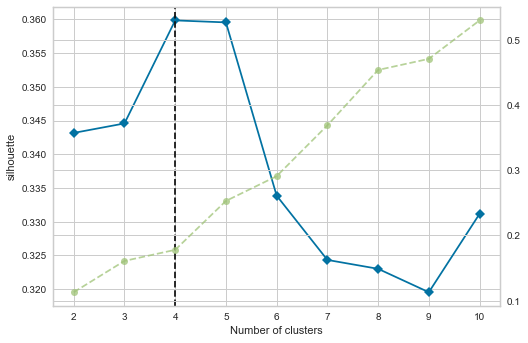

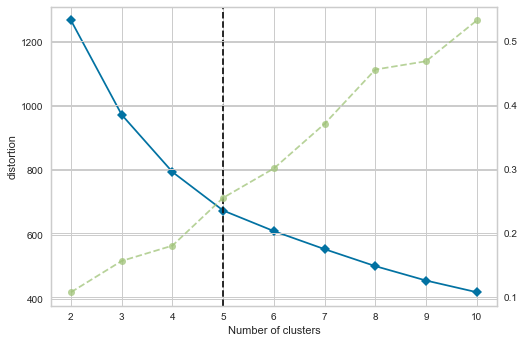

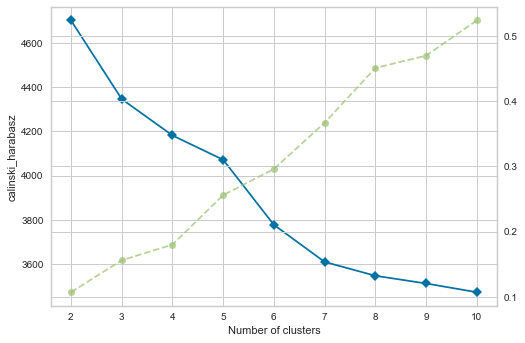

In [9]:
number_clusters(perspective,KMeans( init='k-means++', n_init=15, random_state=1))

#### 4.2.Silhouette Analysis

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
findfon

findfont: score(<Font 'Arial' (ARIALNI.TTF) italic normal 400 condensed>) = 1.25
findfont: score(<Font 'SimSun-ExtB' (simsunb.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Courier New' (cour.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Lucida Sans Unicode' (l_10646.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Rockwell' (ROCKI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Rockwell Extra Bold' (ROCKEB.TTF) normal normal bold normal>) = 10.335
findfont: score(<Font 'Comic Sans MS' (comicz.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Verdana' (verdanab.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Courier New' (courbi.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Arial' (ariali.ttf) italic normal 400 normal>) = 1.05
findfont: score(<Font 'Bodoni MT' (BOD_CB.TTF) normal normal 700 condensed>) = 10.535
findfont: score(<Font 'Comic Sans MS' (comicbd.ttf) normal normal 7

findfont: score(<Font 'Lucida Fax' (LFAXDI.TTF) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Castellar' (CASTELAR.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Bernard MT Condensed' (BERNHC.TTF) normal normal 400 condensed>) = 10.25
findfont: score(<Font 'Malgun Gothic' (malgunbd.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Freestyle Script' (FREESCPT.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Cooper Black' (COOPBL.TTF) normal normal black normal>) = 10.525
findfont: score(<Font 'Maiandra GD' (MAIAN.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Times New Roman' (timesbi.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Candara' (Candaraz.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Ebrima' (ebrimabd.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Candara' (Candara.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Agency FB' (AGENCYB.TTF) n

findfont: score(<Font 'Century Schoolbook' (SCHLBKB.TTF) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Gloucester MT Extra Condensed' (GLECB.TTF) normal normal 400 condensed>) = 10.25
findfont: score(<Font 'Yu Gothic' (YuGothB.ttc) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Century Gothic' (GOTHICBI.TTF) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Tw Cen MT Condensed' (TCCM____.TTF) normal normal 400 condensed>) = 10.25
findfont: score(<Font 'Gill Sans Ultra Bold Condensed' (GILLUBCD.TTF) normal normal bold condensed>) = 10.535
findfont: score(<Font 'Leelawadee' (LEELAWDB.TTF) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Nirmala UI' (NirmalaS.ttf) normal normal light normal>) = 10.24
findfont: score(<Font 'Consolas' (consolab.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Castellar' (CASTELAR.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Footlight MT Light' (FTLTLT.TTF) normal normal light norma

findfont: score(<Font 'Playbill' (PLAYBILL.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Lucida Sans' (LSANSI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Leelawadee' (LEELAWAD.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Malgun Gothic' (malgunbd.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Microsoft Tai Le' (taileb.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Lucida Handwriting' (LHANDW.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Wide Latin' (LATINWD.TTF) normal normal 400 expanded>) = 10.25
findfont: score(<Font 'Segoe UI Historic' (seguihis.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Tw Cen MT' (TCBI____.TTF) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Chiller' (CHILLER.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Segoe UI' (segoeuii.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Baskerville Old Face' (BASKV

findfont: score(<Font 'Arial' (ARIALNB.TTF) normal normal 700 condensed>) = 0.5349999999999999
findfont: score(<Font 'Verdana' (verdana.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Matura MT Script Capitals' (MATURASC.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Malgun Gothic' (malgun.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Tw Cen MT' (TCM_____.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Gill Sans MT' (GILBI___.TTF) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Arial' (ARIALNBI.TTF) italic normal 700 condensed>) = 1.535
findfont: score(<Font 'Century Gothic' (GOTHICBI.TTF) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Harlow Solid Italic' (HARLOWSI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Franklin Gothic Heavy' (FRAHV.TTF) normal normal heavy normal>) = 10.43
findfont: score(<Font 'Rockwell' (ROCKBI.TTF) italic normal 700 normal>) = 11.335
findfont: score(<Font 

findfont: score(<Font 'Segoe Print' (segoepr.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Bodoni MT' (BOD_I.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Old English Text MT' (OLDENGL.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Cambria' (cambria.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Corbel' (corbel.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Century Schoolbook' (SCHLBKBI.TTF) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Franklin Gothic Demi Cond' (FRADMCN.TTF) normal normal demi condensed>) = 10.44
findfont: score(<Font 'Perpetua' (PERB____.TTF) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Lucida Sans' (LSANSDI.TTF) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Leelawadee UI' (LeelaUIb.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Trebuchet MS' (trebucit.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Modern No. 20' 

findfont: score(<Font 'Microsoft JhengHei' (msjhbd.ttc) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Lucida Bright' (LBRITE.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Tw Cen MT' (TCB_____.TTF) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Bodoni MT' (BOD_BLAR.TTF) normal normal black normal>) = 10.525
findfont: score(<Font 'Sitka Small' (SitkaB.ttc) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Segoe MDL2 Assets' (segmdl2.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Tempus Sans ITC' (TEMPSITC.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Segoe UI' (seguisbi.ttf) italic normal semibold normal>) = 11.24
findfont: score(<Font 'Dubai' (DUBAI-REGULAR.TTF) normal normal regular normal>) = 10.05
findfont: score(<Font 'Myanmar Text' (mmrtext.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Book Antiqua' (ANTQUAI.TTF) italic normal book normal>) = 11.05
findfont: score(<Font 'Candara' (C

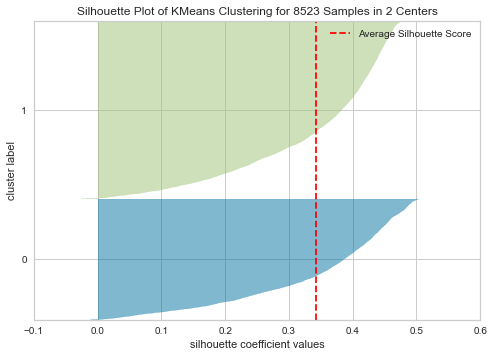

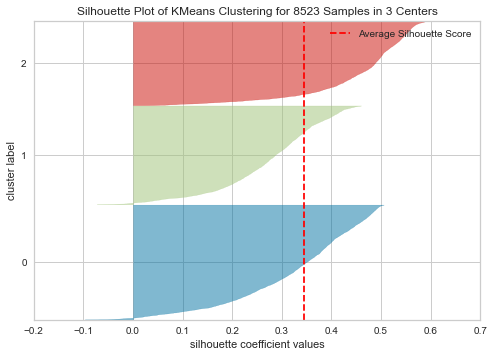

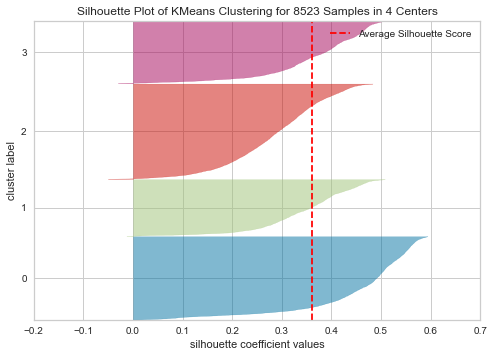

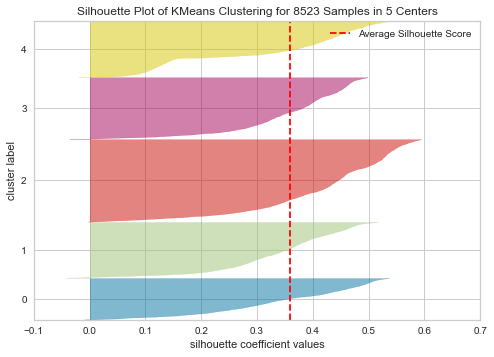

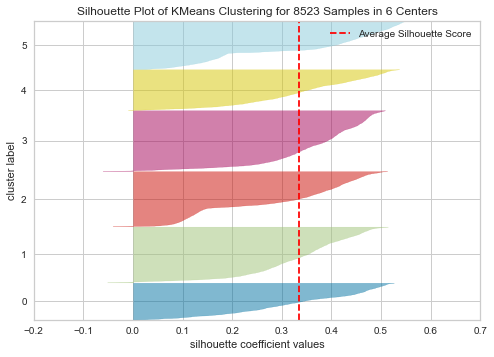

In [10]:
[SilhouetteVisualizer(KMeans(n_clusters=i,init='k-means++', n_init=15, random_state=1), colors='yellowbrick').fit(perspective).show() for i in range(2,7)]

#### 4.3.Applying the clustering

In [11]:
#According to the KElbowVisualizer and the SilhouetteVisualizer we were able to determine that the optimal number of clusters is 5.
#confirmar nº de k
kmclust = KMeans(n_clusters=5, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(perspective)
df_concat = pd.concat((perspective, pd.Series(km_labels, name='labels')), axis=1)
df_concat.groupby('labels').mean()

Age       Edu    Income   Kidhome  Teenhome
labels                                                  
0       0.051569  0.252208  0.044170 -0.186528  0.241434
1       0.199649  0.011761  0.179032 -0.123775 -0.192797
2      -0.131859 -0.005243 -0.121439  0.278757  0.218943
3      -0.241770 -0.000185 -0.222684  0.199132 -0.213375
4       0.050218 -0.174604  0.040824 -0.197968  0.246754

In [12]:
#Making a copy of the dataset and appending a column with the cluster assigned to the observation.
km_perspective = perspective.copy()
km_perspective["km_labels"] = km_labels

### 4.4. Cluster Profile

TypeError: annotate() missing 1 required positional argument: 's'

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=11.0.
findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 3.335
findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 2.05
findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 2.335
findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
findfont: 

findfont: score(<Font 'Arial' (ARIALNI.TTF) italic normal 400 condensed>) = 1.25
findfont: score(<Font 'SimSun-ExtB' (simsunb.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Courier New' (cour.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Lucida Sans Unicode' (l_10646.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Rockwell' (ROCKI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Rockwell Extra Bold' (ROCKEB.TTF) normal normal bold normal>) = 10.335
findfont: score(<Font 'Comic Sans MS' (comicz.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Verdana' (verdanab.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Courier New' (courbi.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Arial' (ariali.ttf) italic normal 400 normal>) = 1.05
findfont: score(<Font 'Bodoni MT' (BOD_CB.TTF) normal normal 700 condensed>) = 10.535
findfont: score(<Font 'Comic Sans MS' (comicbd.ttf) normal normal 7

findfont: score(<Font 'Lucida Fax' (LFAXDI.TTF) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Castellar' (CASTELAR.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Bernard MT Condensed' (BERNHC.TTF) normal normal 400 condensed>) = 10.25
findfont: score(<Font 'Malgun Gothic' (malgunbd.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Freestyle Script' (FREESCPT.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Cooper Black' (COOPBL.TTF) normal normal black normal>) = 10.525
findfont: score(<Font 'Maiandra GD' (MAIAN.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Times New Roman' (timesbi.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Candara' (Candaraz.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Ebrima' (ebrimabd.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Candara' (Candara.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Agency FB' (AGENCYB.TTF) n

findfont: score(<Font 'Century Schoolbook' (SCHLBKB.TTF) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Gloucester MT Extra Condensed' (GLECB.TTF) normal normal 400 condensed>) = 10.25
findfont: score(<Font 'Yu Gothic' (YuGothB.ttc) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Century Gothic' (GOTHICBI.TTF) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Tw Cen MT Condensed' (TCCM____.TTF) normal normal 400 condensed>) = 10.25
findfont: score(<Font 'Gill Sans Ultra Bold Condensed' (GILLUBCD.TTF) normal normal bold condensed>) = 10.535
findfont: score(<Font 'Leelawadee' (LEELAWDB.TTF) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Nirmala UI' (NirmalaS.ttf) normal normal light normal>) = 10.24
findfont: score(<Font 'Consolas' (consolab.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Castellar' (CASTELAR.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Footlight MT Light' (FTLTLT.TTF) normal normal light norma

findfont: score(<Font 'Playbill' (PLAYBILL.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Lucida Sans' (LSANSI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Leelawadee' (LEELAWAD.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Malgun Gothic' (malgunbd.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Microsoft Tai Le' (taileb.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Lucida Handwriting' (LHANDW.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Wide Latin' (LATINWD.TTF) normal normal 400 expanded>) = 10.25
findfont: score(<Font 'Segoe UI Historic' (seguihis.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Tw Cen MT' (TCBI____.TTF) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Chiller' (CHILLER.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Segoe UI' (segoeuii.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Baskerville Old Face' (BASKV

findfont: score(<Font 'Arial' (ARIALNB.TTF) normal normal 700 condensed>) = 0.5349999999999999
findfont: score(<Font 'Verdana' (verdana.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Matura MT Script Capitals' (MATURASC.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Malgun Gothic' (malgun.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Tw Cen MT' (TCM_____.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Gill Sans MT' (GILBI___.TTF) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Arial' (ARIALNBI.TTF) italic normal 700 condensed>) = 1.535
findfont: score(<Font 'Century Gothic' (GOTHICBI.TTF) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Harlow Solid Italic' (HARLOWSI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Franklin Gothic Heavy' (FRAHV.TTF) normal normal heavy normal>) = 10.43
findfont: score(<Font 'Rockwell' (ROCKBI.TTF) italic normal 700 normal>) = 11.335
findfont: score(<Font 

findfont: score(<Font 'Segoe Print' (segoepr.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Bodoni MT' (BOD_I.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Old English Text MT' (OLDENGL.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Cambria' (cambria.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Corbel' (corbel.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Century Schoolbook' (SCHLBKBI.TTF) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Franklin Gothic Demi Cond' (FRADMCN.TTF) normal normal demi condensed>) = 10.44
findfont: score(<Font 'Perpetua' (PERB____.TTF) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Lucida Sans' (LSANSDI.TTF) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Leelawadee UI' (LeelaUIb.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Trebuchet MS' (trebucit.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Modern No. 20' 

findfont: score(<Font 'Microsoft JhengHei' (msjhbd.ttc) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Lucida Bright' (LBRITE.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Tw Cen MT' (TCB_____.TTF) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Bodoni MT' (BOD_BLAR.TTF) normal normal black normal>) = 10.525
findfont: score(<Font 'Sitka Small' (SitkaB.ttc) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Segoe MDL2 Assets' (segmdl2.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Tempus Sans ITC' (TEMPSITC.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Segoe UI' (seguisbi.ttf) italic normal semibold normal>) = 11.24
findfont: score(<Font 'Dubai' (DUBAI-REGULAR.TTF) normal normal regular normal>) = 10.05
findfont: score(<Font 'Myanmar Text' (mmrtext.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Book Antiqua' (ANTQUAI.TTF) italic normal book normal>) = 11.05
findfont: score(<Font 'Candara' (C

findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal regular normal>) = 10.05
findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'STIXSizeThreeSym' 

findfont: score(<Font 'Mistral' (MISTRAL.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Cambria' (cambria.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Showcard Gothic' (SHOWG.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Lucida Sans Typewriter' (LTYPEB.TTF) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Candara' (Candarali.ttf) italic normal light normal>) = 11.24
findfont: score(<Font 'Lucida Bright' (LBRITEDI.TTF) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Microsoft Himalaya' (himalaya.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Book Antiqua' (ANTQUABI.TTF) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Nirmala UI' (NirmalaS.ttf) normal normal light normal>) = 10.24
findfont: score(<Font 'Algerian' (ALGER.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Bookshelf Symbol 7' (BSSYM7.TTF) normal normal book normal>) = 10.05
findfont: score(<Font 'Kunstler Script' (

findfont: score(<Font 'Magneto' (MAGNETOB.TTF) normal normal 700 normal>) = 10.335
findfont: score(<Font 'SimSun-ExtB' (simsunb.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Bodoni MT' (BOD_CI.TTF) italic normal 400 condensed>) = 11.25
findfont: score(<Font 'Marlett' (marlett.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Californian FB' (CALIFI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Harrington' (HARNGTON.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Calibri' (calibriz.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Copperplate Gothic Bold' (COPRGTB.TTF) normal normal bold normal>) = 10.335
findfont: score(<Font 'Segoe UI' (segoeuib.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'OCR A Extended' (OCRAEXT.TTF) normal normal 400 expanded>) = 10.25
findfont: score(<Font 'Poor Richard' (POORICH.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Century Gothic' (GOTHIC.TTF) 

findfont: score(<Font 'Berlin Sans FB' (BRLNSR.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Palatino Linotype' (palab.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Bookman Old Style' (BOOKOSB.TTF) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Britannic Bold' (BRITANIC.TTF) normal normal bold normal>) = 10.335
findfont: score(<Font 'Broadway' (BROADW.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Perpetua Titling MT' (PERTILI.TTF) normal normal light normal>) = 10.24
findfont: score(<Font 'Consolas' (consola.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Haettenschweiler' (HATTEN.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Lucida Console' (lucon.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Tw Cen MT Condensed' (TCCM____.TTF) normal normal 400 condensed>) = 10.25
findfont: score(<Font 'Kunstler Script' (KUNSTLER.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Fon

findfont: score(<Font 'Stencil' (STENCIL.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Calisto MT' (CALISTI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Pristina' (PRISTINA.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Yu Gothic' (YuGothM.ttc) normal normal medium normal>) = 10.145
findfont: score(<Font 'Times New Roman' (timesbi.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Microsoft Yi Baiti' (msyi.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'MS Outlook' (OUTLOOK.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Bodoni MT' (BOD_B.TTF) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Palatino Linotype' (pala.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Gloucester MT Extra Condensed' (GLECB.TTF) normal normal 400 condensed>) = 10.25
findfont: score(<Font 'Gill Sans MT Condensed' (GILC____.TTF) normal normal 400 condensed>) = 10.25
findfont: score(<Font 'Arial

findfont: score(<Font 'Bodoni MT' (BOD_CBI.TTF) italic normal 700 condensed>) = 11.535
findfont: score(<Font 'Symbol' (symbol.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Dubai' (DUBAI-MEDIUM.TTF) normal normal medium normal>) = 10.145
findfont: score(<Font 'Agency FB' (AGENCYR.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Consolas' (consolaz.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Blackadder ITC' (ITCBLKAD.TTF) normal normal black normal>) = 10.525
findfont: score(<Font 'Bodoni MT' (BOD_CI.TTF) italic normal 400 condensed>) = 11.25
findfont: score(<Font 'Garamond' (GARAIT.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'OCR A Extended' (OCRAEXT.TTF) normal normal 400 expanded>) = 10.25
findfont: score(<Font 'Segoe Script' (segoesc.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Freestyle Script' (FREESCPT.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Leelawadee' (LEELAWAD.TTF) norm

findfont: score(<Font 'Perpetua' (PERI____.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Footlight MT Light' (FTLTLT.TTF) normal normal light normal>) = 10.24
findfont: score(<Font 'Tw Cen MT' (TCB_____.TTF) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Perpetua Titling MT' (PERTIBD.TTF) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Javanese Text' (javatext.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Ebrima' (ebrima.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'MS Reference Sans Serif' (REFSAN.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Perpetua' (PERBI___.TTF) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Segoe UI Historic' (seguihis.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Nirmala UI' (NirmalaB.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Segoe UI' (segoeuisl.ttf) normal normal light normal>) = 10.24
findfont: score(<Font 'Goudy Stout

findfont: score(<Font 'Century Gothic' (GOTHICI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Arial' (ARIALNBI.TTF) italic normal 700 condensed>) = 1.535
findfont: score(<Font 'Corbel' (corbell.ttf) normal normal light normal>) = 10.24
findfont: score(<Font 'Constantia' (constanb.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Goudy Old Style' (GOUDOSI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Showcard Gothic' (SHOWG.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Nirmala UI' (Nirmala.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Trebuchet MS' (trebucbd.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Candara' (Candarab.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Microsoft Uighur' (MSUIGHUB.TTF) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Bookman Old Style' (BOOKOSI.TTF) italic normal book normal>) = 11.05
findfont: score(<Font 'Broadway' (BROADW.TTF) 

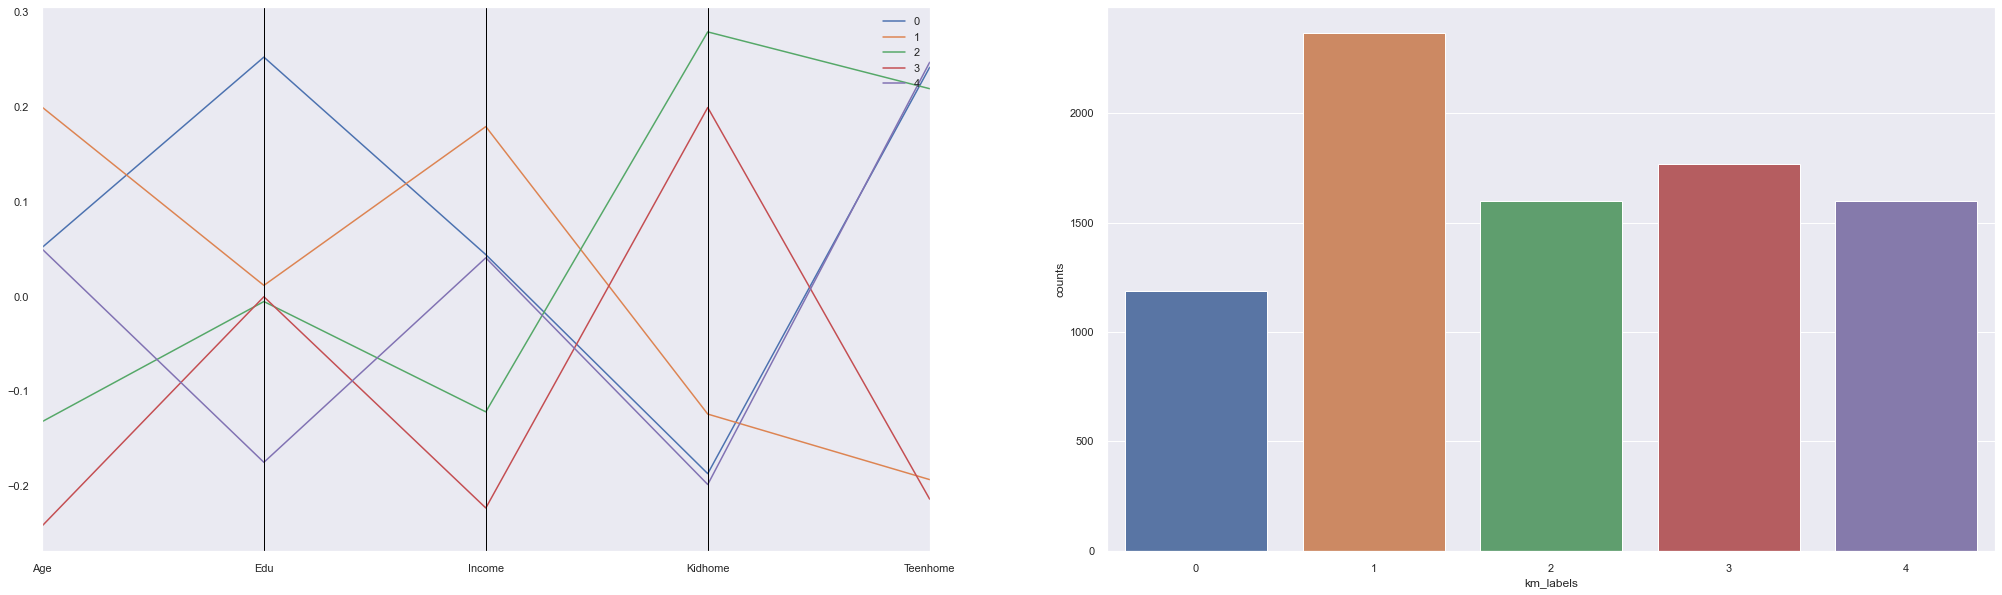

In [13]:
cluster_profiles(km_perspective, ["km_labels"],(35,10), compar_titles=None)

# 5.GMM
### 5.1.Choosing the type of covariance

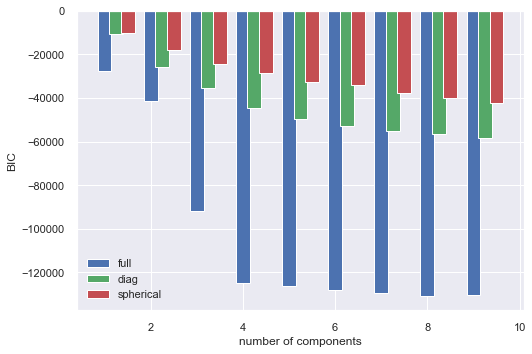

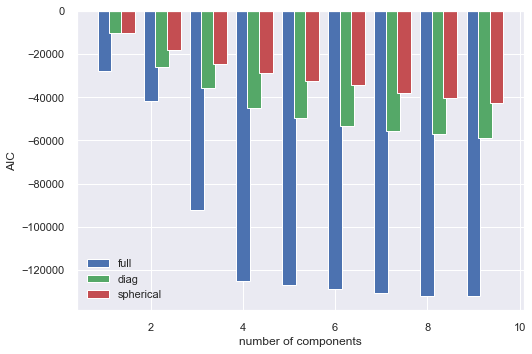

In [14]:
gmm_config(perspective,10)

In [15]:
#For the most part, the number of components the model with the lowest AIC and BIC is 'full' 

### 5.2.Find the number of components

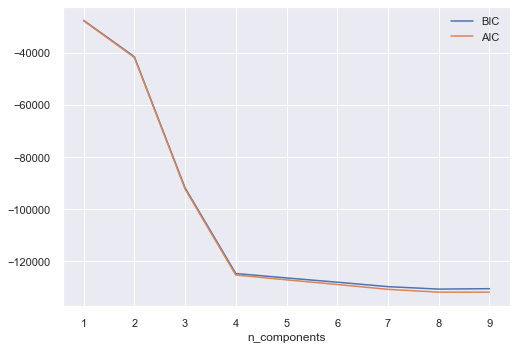

In [16]:
gmm_components(perspective,'full',1,10) #escolher tipo onde esta 'full'

In [17]:
#According to the graph, the teams considers the optimal number of components is 3.

### 5.3.Applying the clustering

In [21]:
# Performing GMM clustering
gmm = GaussianMixture(n_components=4, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)
gmm_labels = gmm.fit_predict(perspective)
# Concatenating the labels to df
df_concat = pd.concat([perspective, pd.Series(gmm_labels, index=perspective.index, name="gmm_labels")], axis=1)
df_concat.head()

Age       Edu    Income   Kidhome  Teenhome  gmm_labels
0  0.084213  0.492809  0.055831 -0.229303 -0.296554           0
1  0.260030  0.093857  0.207936 -0.132845 -0.171806           0
2 -0.064435 -0.071185 -0.056779  0.151771  0.117353           1
3 -0.052335 -0.143322 -0.075243 -0.194696  0.236278           2
4  0.049439  0.369257  0.027139 -0.171815 -0.222205           0

In [22]:
gmm_perspective = perspective.copy()
gmm_perspective["gmm_labels"] = gmm_labels

### 5.4.Cluster Profilling

TypeError: annotate() missing 1 required positional argument: 's'

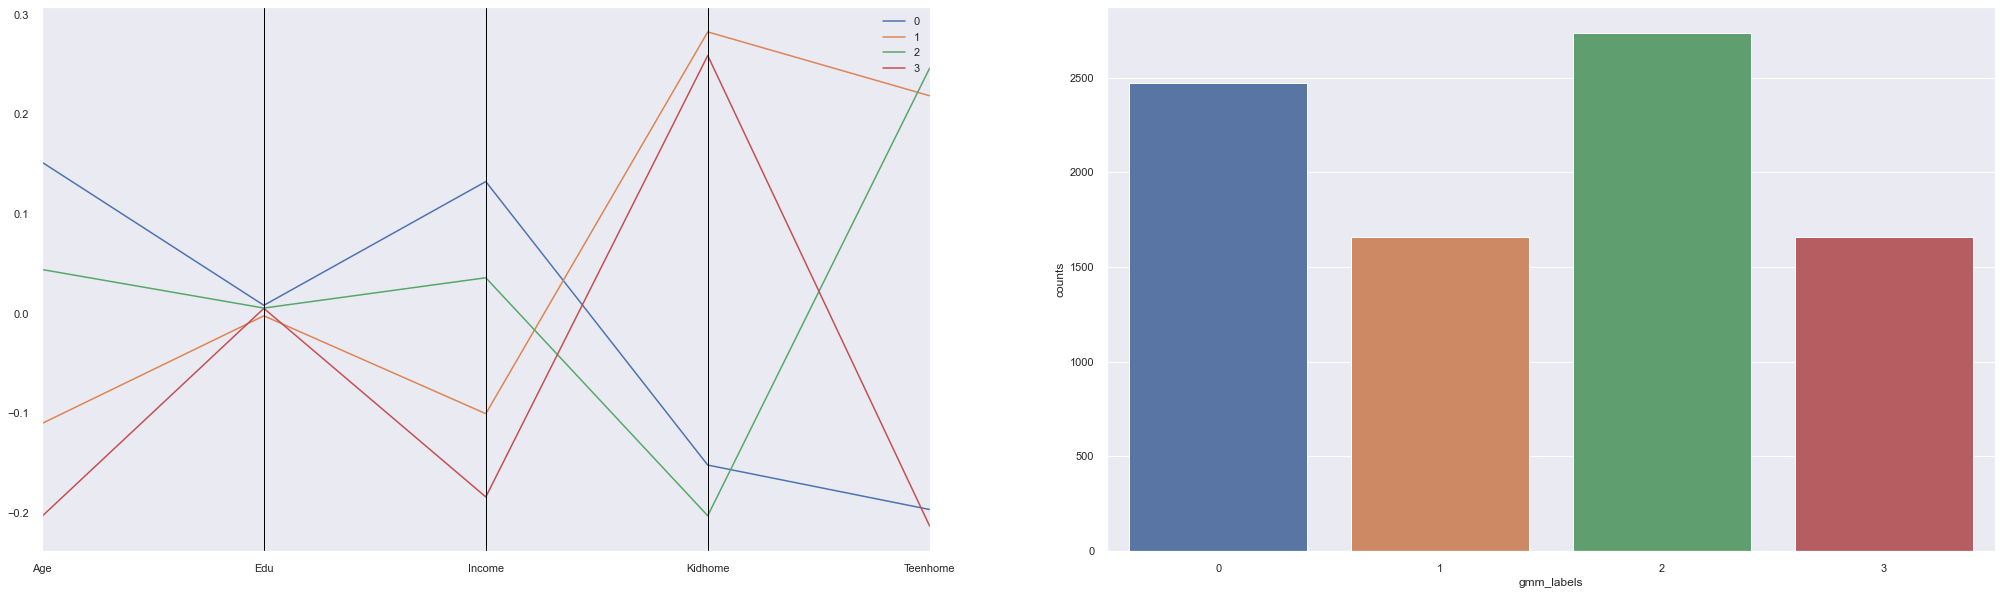

In [23]:
cluster_profiles(gmm_perspective, ["gmm_labels"], (35,10) , compar_titles=None)

# 6.SOM

### 6.1.Clustering with SOMs: K-means SOM and  Hierarchical Clustering SOM

In [24]:
# This som implementation does not have a random seed parameter
# We're going to set it up ourselves
np.random.seed(42)

# Notice that the SOM did not converge - We're under a time constraint for this class
sm = sompy.SOMFactory().build(
    perspective.values, 
    mapsize=(50, 50), 
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    
)
sm.train(n_job=-1, verbose='info', train_rough_len=100, train_finetune_len=100)

 Training...
 random_initialization took: 0.000000 seconds
 Rough training...
 radius_ini: 17.000000 , radius_final: 2.833333, trainlen: 100

 epoch: 1 ---> elapsed time:  0.402000, quantization error: 0.677697

 epoch: 2 ---> elapsed time:  0.494000, quantization error: 2.157917

 epoch: 3 ---> elapsed time:  0.501000, quantization error: 2.133567

 epoch: 4 ---> elapsed time:  0.483000, quantization error: 2.116056

 epoch: 5 ---> elapsed time:  0.495000, quantization error: 2.103216

 epoch: 6 ---> elapsed time:  0.528000, quantization error: 2.100235

 epoch: 7 ---> elapsed time:  0.469000, quantization error: 2.098646

 epoch: 8 ---> elapsed time:  0.473000, quantization error: 2.097305

 epoch: 9 ---> elapsed time:  0.478000, quantization error: 2.096030

 epoch: 10 ---> elapsed time:  0.482000, quantization error: 2.094645

 epoch: 11 ---> elapsed time:  0.487000, quantization error: 2.093029

 epoch: 12 ---> elapsed time:  0.480000, quantization error: 2.091582

 epoch: 13 --->

 epoch: 14 ---> elapsed time:  0.538000, quantization error: 1.265869

 epoch: 15 ---> elapsed time:  0.503000, quantization error: 1.257726

 epoch: 16 ---> elapsed time:  0.471000, quantization error: 1.249628

 epoch: 17 ---> elapsed time:  0.455000, quantization error: 1.241375

 epoch: 18 ---> elapsed time:  0.455000, quantization error: 1.233140

 epoch: 19 ---> elapsed time:  0.453000, quantization error: 1.224848

 epoch: 20 ---> elapsed time:  0.515000, quantization error: 1.216346

 epoch: 21 ---> elapsed time:  0.498000, quantization error: 1.207752

 epoch: 22 ---> elapsed time:  0.470000, quantization error: 1.198956

 epoch: 23 ---> elapsed time:  0.467000, quantization error: 1.190052

 epoch: 24 ---> elapsed time:  0.464000, quantization error: 1.181071

 epoch: 25 ---> elapsed time:  0.454000, quantization error: 1.172019

 epoch: 26 ---> elapsed time:  0.477000, quantization error: 1.162786

 epoch: 27 ---> elapsed time:  0.468000, quantization error: 1.153451

 epoch

In [25]:
# Coordinates of the units in the input space
som_units=sm.get_node_vectors()

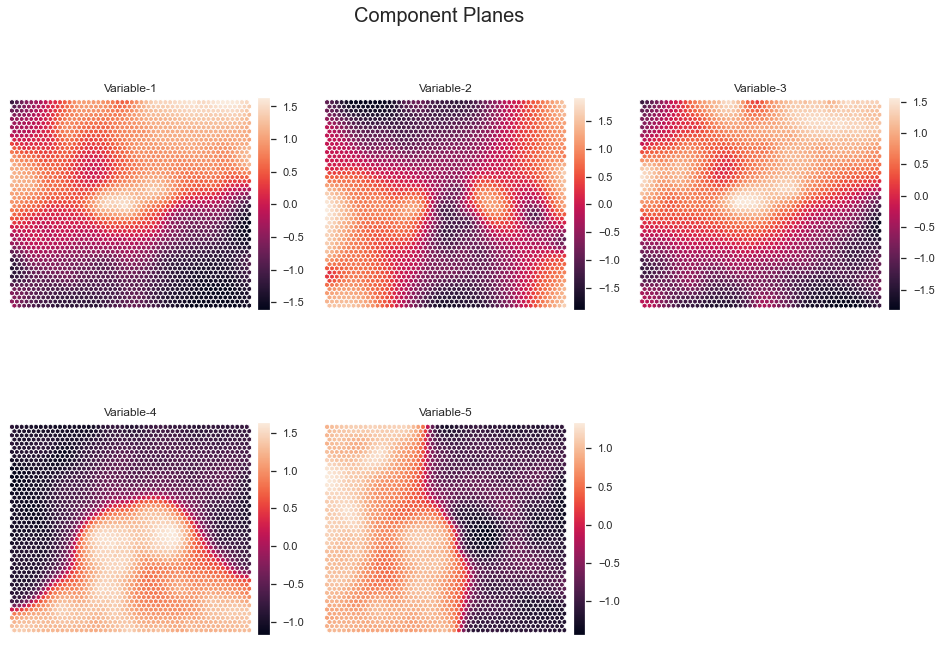

In [26]:
# Component planes on the 50x50 grid
sns.set()
view2D = View2D(12,12,"", text_size=10)
view2D.show(sm, col_sz=3, what='codebook')
plt.subplots_adjust(top=0.90)
plt.suptitle("Component Planes", fontsize=20)
plt.show()

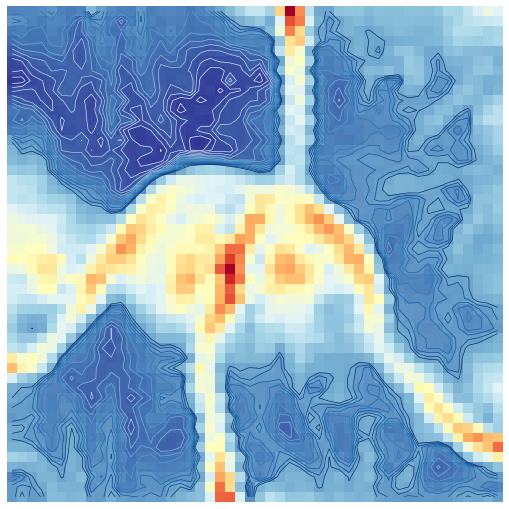

In [27]:
# U-matrix of the 50x50 grid
u = sompy.umatrix.UMatrixView(12, 12, 'umatrix', show_axis=True, text_size=8, show_text=True)

UMAT = u.show(
    sm, 
    distance2=1, 
    row_normalized=False, 
    show_data=False, 
    contooor=True # Visualize isomorphic curves
)

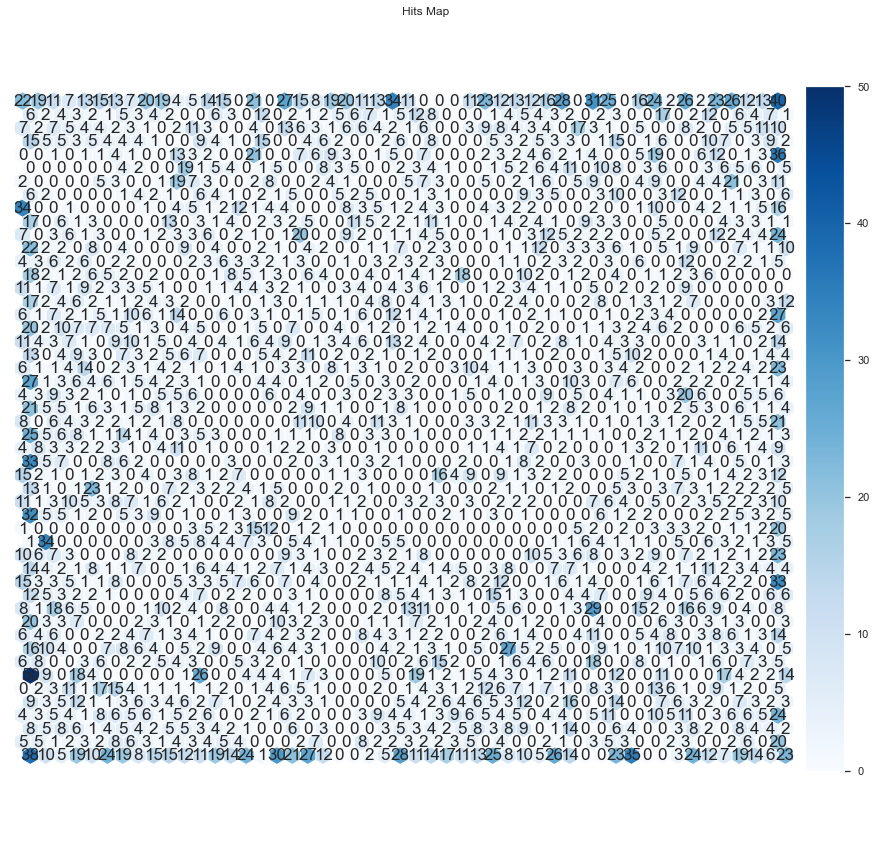

In [28]:
#HIT-MAP
vhts  = BmuHitsView(15,15,"Hits Map")
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=17, cmap="Blues")
plt.show()

### 6.1.K-Means on top of SOM units
#### 6.1.1.Number of clusters 

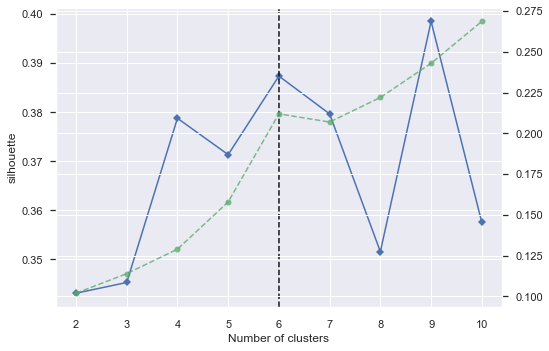

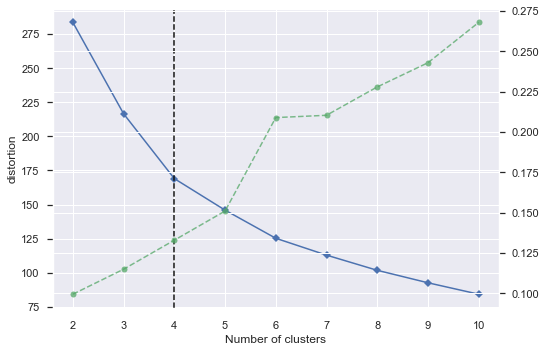

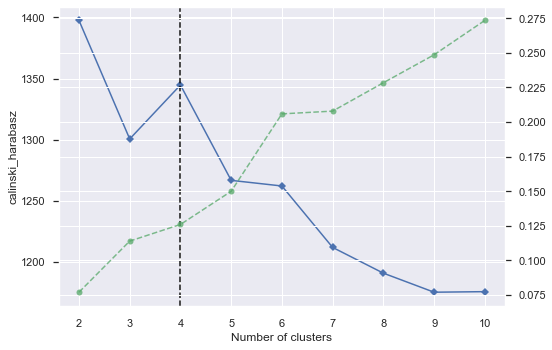

In [29]:
number_clusters(som_units,KMeans( init='k-means++', n_init=15, random_state=1))

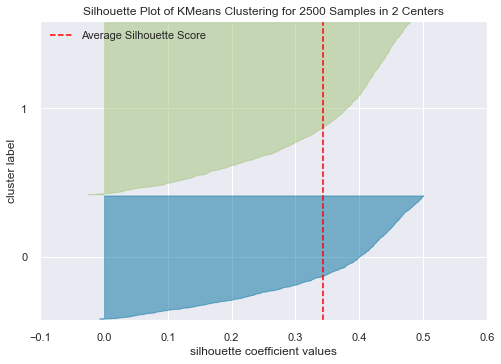

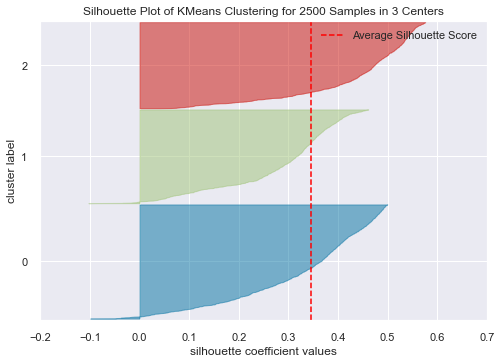

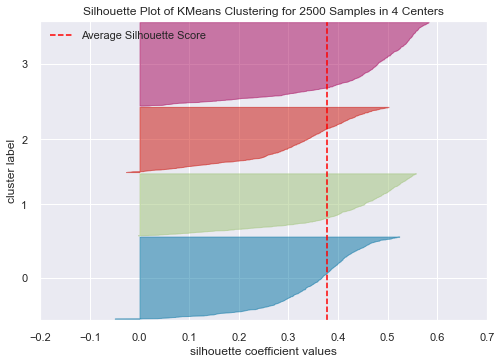

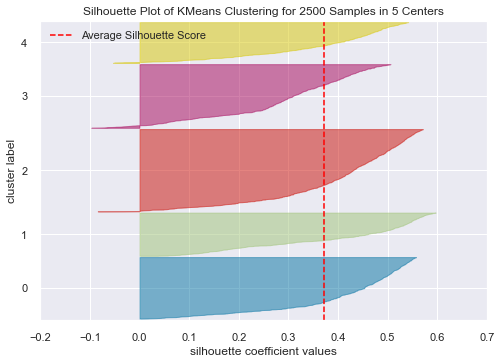

In [30]:
[SilhouetteVisualizer(KMeans(n_clusters=i,init='k-means++', n_init=15, random_state=1), colors='yellowbrick').fit(som_units).show() for i in range(2,6)]

#### 6.1.3.Apply the clustering 

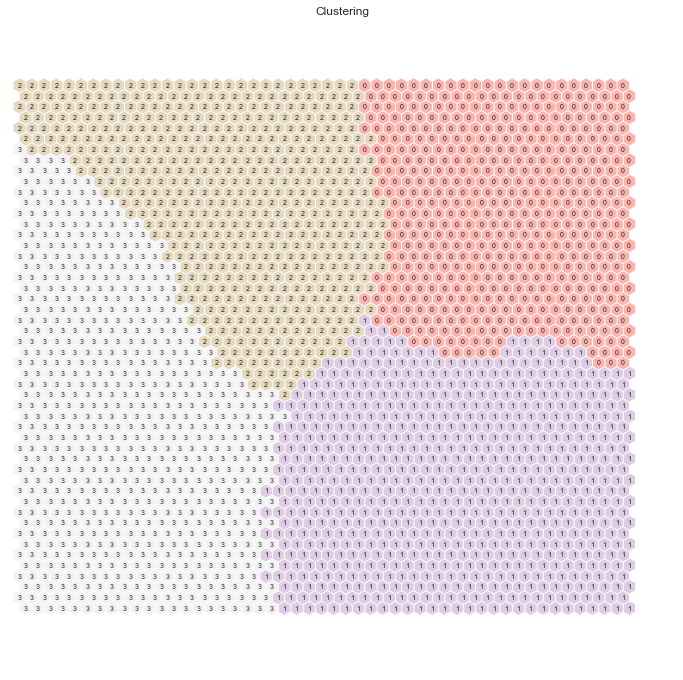

In [31]:
# Perform K-Means clustering on top of the 2500 untis (sm.get_node_vectors() output)
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=20, random_state=42)
nodeclus_labels_KM = sm.cluster(kmeans)

hits  = HitMapView(12, 12,"Clustering", text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [32]:
perspective_nodes_KM = pd.DataFrame(som_units)
perspective_nodes_KM['label'] = nodeclus_labels_KM
perspective_nodes_KM

0         1         2         3         4  label
0     0.294241  0.328318  0.255665 -0.173780 -0.224746      1
1     0.299857  0.293508  0.254503 -0.177358 -0.229374      1
2     0.318284  0.261950  0.255577 -0.179224 -0.231787      1
3     0.320537  0.229506  0.260984 -0.176253 -0.227945      1
4     0.324392  0.191423  0.247821 -0.187238 -0.242152      1
...        ...       ...       ...       ...       ...    ...
2495 -0.191512  0.347283 -0.149322  0.299661  0.232562      2
2496 -0.173153  0.346957 -0.114182  0.309925  0.240872      2
2497 -0.153729  0.339242 -0.077785  0.318402  0.247596      2
2498 -0.122801  0.341116 -0.053398  0.317425  0.246876      2
2499 -0.079278  0.339414 -0.057093  0.309550  0.240982      2

[2500 rows x 6 columns]

In [33]:
# Obtaining SOM's BMUs labels
bmus_map = sm.find_bmu(perspective)[0]  # get bmus for each observation in df

perspective_bmus = pd.DataFrame(
    np.concatenate((perspective, np.expand_dims(bmus_map,1)), axis=1),
    index=perspective.index, columns=np.append(perspective.columns,"BMU")
)
perspective_bmus

Age       Edu    Income   Kidhome  Teenhome     BMU
0     0.084213  0.492809  0.055831 -0.229303 -0.296554  1110.0
1     0.260030  0.093857  0.207936 -0.132845 -0.171806   879.0
2    -0.064435 -0.071185 -0.056779  0.151771  0.117353   930.0
3    -0.052335 -0.143322 -0.075243 -0.194696  0.236278   882.0
4     0.049439  0.369257  0.027139 -0.171815 -0.222205  1160.0
...        ...       ...       ...       ...       ...     ...
8518 -0.120378 -0.174670 -0.181239  0.372409  0.287957  1787.0
8519 -0.103435  0.124530 -0.268898  0.276639  0.213905  1788.0
8520  0.069282  0.282930  0.048791 -0.131647  0.159763   983.0
8521  0.239382 -0.280947  0.106683 -0.192765 -0.249300   828.0
8522  0.091191 -0.182785  0.263354 -0.248304  0.301335   880.0

[8523 rows x 6 columns]

In [34]:
# Get cluster labels for each observation
perspective_final_KMSOM =perspective_bmus.merge(perspective_nodes_KM['label'], 'left', left_on="BMU", right_index=True)
perspective_final_KMSOM

Age       Edu    Income   Kidhome  Teenhome     BMU  label
0     0.084213  0.492809  0.055831 -0.229303 -0.296554  1110.0      1
1     0.260030  0.093857  0.207936 -0.132845 -0.171806   879.0      3
2    -0.064435 -0.071185 -0.056779  0.151771  0.117353   930.0      3
3    -0.052335 -0.143322 -0.075243 -0.194696  0.236278   882.0      3
4     0.049439  0.369257  0.027139 -0.171815 -0.222205  1160.0      1
...        ...       ...       ...       ...       ...     ...    ...
8518 -0.120378 -0.174670 -0.181239  0.372409  0.287957  1787.0      2
8519 -0.103435  0.124530 -0.268898  0.276639  0.213905  1788.0      2
8520  0.069282  0.282930  0.048791 -0.131647  0.159763   983.0      3
8521  0.239382 -0.280947  0.106683 -0.192765 -0.249300   828.0      1
8522  0.091191 -0.182785  0.263354 -0.248304  0.301335   880.0      3

[8523 rows x 7 columns]

In [35]:
# Characterizing the final clusters
perspective_final_KMSOM.drop(columns='BMU').groupby('label').mean()

Age       Edu    Income   Kidhome  Teenhome
label                                                  
0     -0.257264 -0.001375 -0.236819  0.215902 -0.213021
1      0.192782  0.017129  0.163732 -0.123738 -0.218453
2     -0.159792  0.041662 -0.152353  0.286167  0.215071
3      0.062115 -0.011046  0.059115 -0.134804  0.169064

### 6.1.4.Cluster Profiles

TypeError: annotate() missing 1 required positional argument: 's'

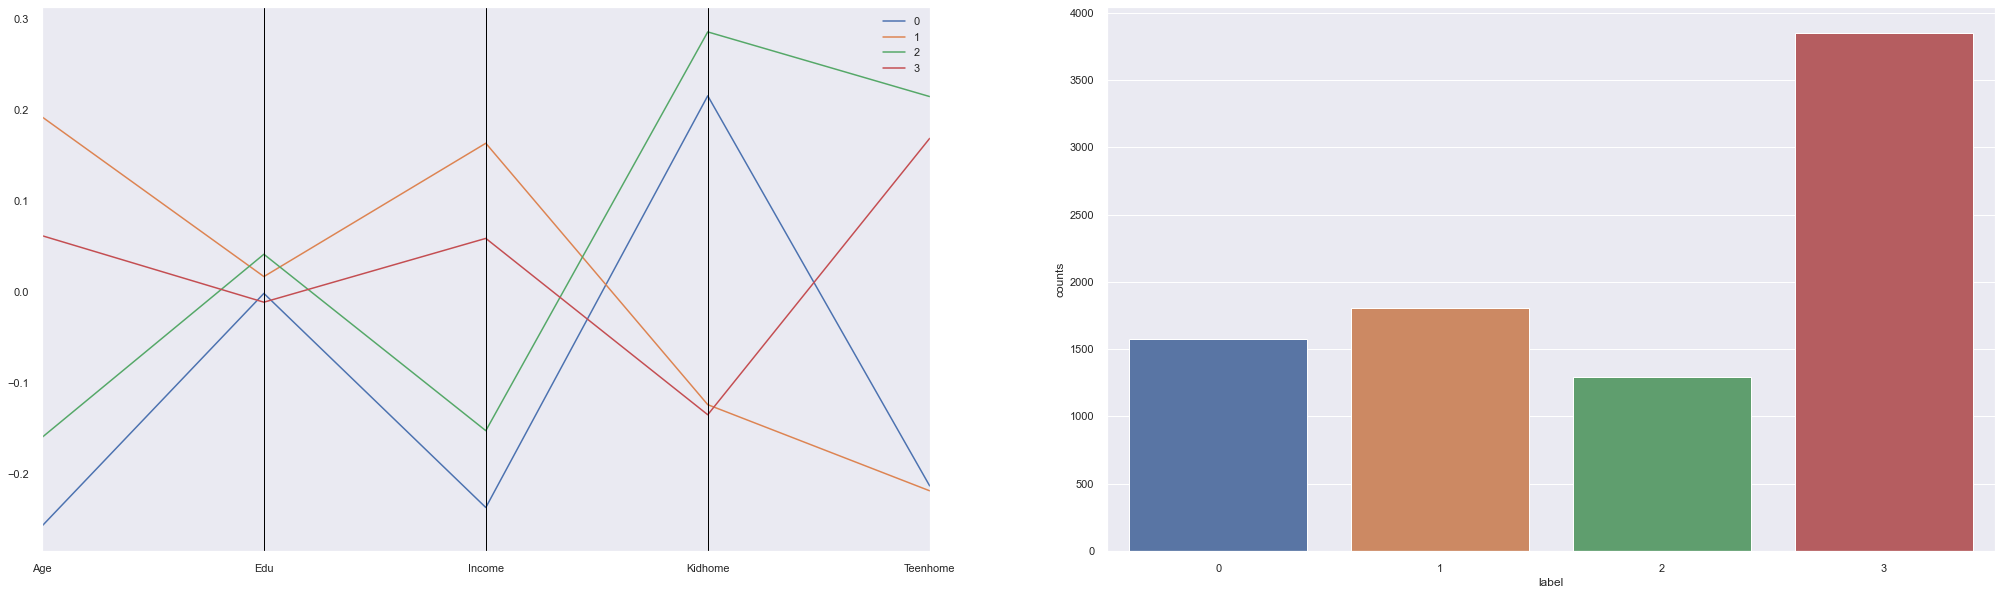

In [36]:
cluster_profiles(perspective_final_KMSOM.drop('BMU',axis=1), ["label"], (35,10), compar_titles=None)

### 6.2.Hierarchical Clustering on top of SOM units
#### 6.2.1.R2 plot

NumExpr defaulting to 8 threads.


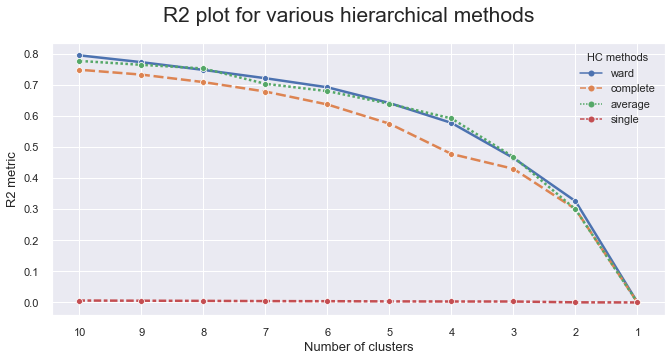

In [37]:
# Prepare input
hc_methods = ["ward", "complete", "average", "single"]
# Call function defined above to obtain the R2 statistic for each hc_method
max_nclus = 10
r2_hc_methods = np.vstack([get_r2_hc(df=pd.DataFrame(som_units), link_method=link, max_nclus=max_nclus) for link in hc_methods]).T
r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
plt.gca().invert_xaxis()  # invert x axis
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

plt.show()

#### 6.2.2.Dendrogram

In [38]:
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(pd.DataFrame(som_units))

array([1561, 2060, 1774, ...,    4,    1,    0], dtype=int64)

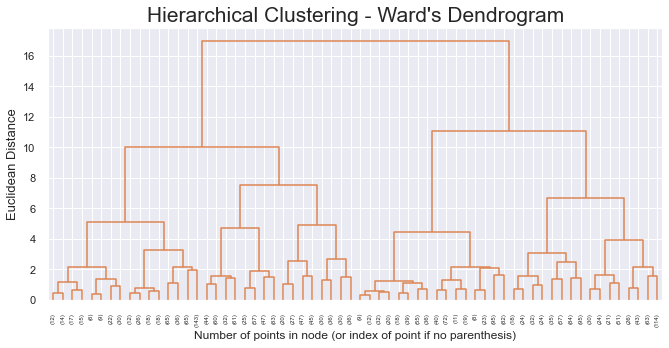

In [39]:
# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# setting the threshold
y_threshold = 30
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

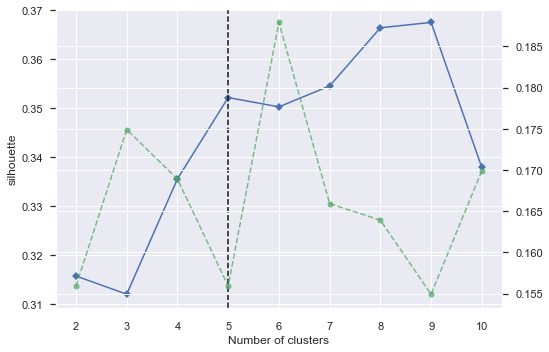

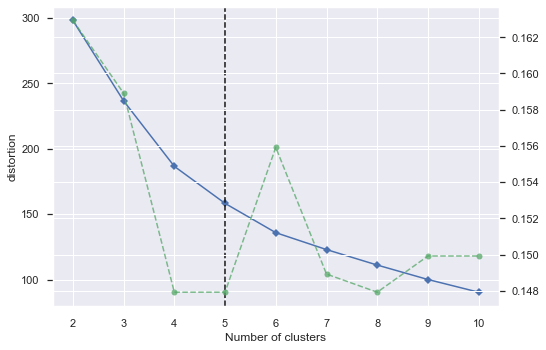

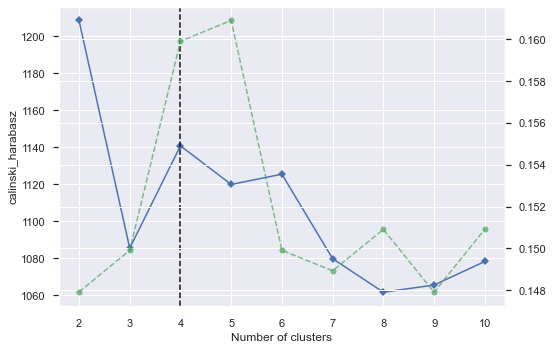

In [40]:
number_clusters(som_units, AgglomerativeClustering(linkage=linkage))

#### 6.2.4.Applying the Clustering

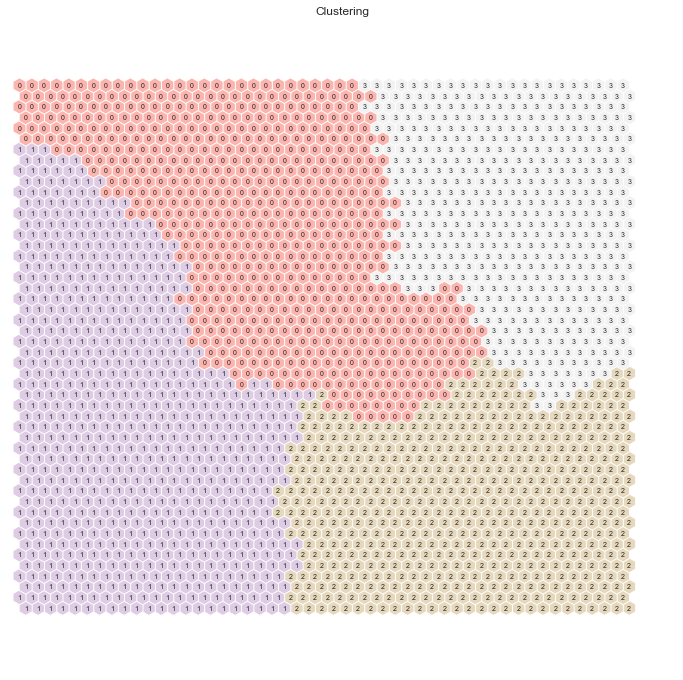

In [48]:
# Perform Hierarchical clustering on top of the 2500 untis (sm.get_node_vectors() output)
hierclust = AgglomerativeClustering(n_clusters=4, linkage='ward')
nodeclus_labels_HC= sm.cluster(hierclust)

hits  = HitMapView(12, 12,"Clustering",text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [49]:
# Check the nodes and and respective clusters
nodes = sm.get_node_vectors()

perspective_nodes_HC = pd.DataFrame(nodes)
perspective_nodes_HC['label'] = nodeclus_labels_HC
perspective_nodes_HC

0         1         2         3         4  label
0     0.294241  0.328318  0.255665 -0.173780 -0.224746      2
1     0.299857  0.293508  0.254503 -0.177358 -0.229374      2
2     0.318284  0.261950  0.255577 -0.179224 -0.231787      2
3     0.320537  0.229506  0.260984 -0.176253 -0.227945      2
4     0.324392  0.191423  0.247821 -0.187238 -0.242152      2
...        ...       ...       ...       ...       ...    ...
2495 -0.191512  0.347283 -0.149322  0.299661  0.232562      0
2496 -0.173153  0.346957 -0.114182  0.309925  0.240872      0
2497 -0.153729  0.339242 -0.077785  0.318402  0.247596      0
2498 -0.122801  0.341116 -0.053398  0.317425  0.246876      0
2499 -0.079278  0.339414 -0.057093  0.309550  0.240982      0

[2500 rows x 6 columns]

In [50]:
# Obtaining SOM's BMUs labels
bmus_map = sm.find_bmu(perspective)[0]  # get bmus for each observation in df

perspective_bmus = pd.DataFrame(
    np.concatenate((perspective, np.expand_dims(bmus_map,1)), axis=1),
    index=perspective.index, columns=np.append(perspective.columns,"BMU")
)
perspective_bmus

Age       Edu    Income   Kidhome  Teenhome     BMU
0     0.084213  0.492809  0.055831 -0.229303 -0.296554  1110.0
1     0.260030  0.093857  0.207936 -0.132845 -0.171806   879.0
2    -0.064435 -0.071185 -0.056779  0.151771  0.117353   930.0
3    -0.052335 -0.143322 -0.075243 -0.194696  0.236278   882.0
4     0.049439  0.369257  0.027139 -0.171815 -0.222205  1160.0
...        ...       ...       ...       ...       ...     ...
8518 -0.120378 -0.174670 -0.181239  0.372409  0.287957  1787.0
8519 -0.103435  0.124530 -0.268898  0.276639  0.213905  1788.0
8520  0.069282  0.282930  0.048791 -0.131647  0.159763   983.0
8521  0.239382 -0.280947  0.106683 -0.192765 -0.249300   828.0
8522  0.091191 -0.182785  0.263354 -0.248304  0.301335   880.0

[8523 rows x 6 columns]

In [51]:
# Get cluster labels for each observation
perspective_final_HC = perspective_bmus.merge(perspective_nodes_HC['label'], 'left', left_on="BMU", right_index=True)
perspective_final_HC

Age       Edu    Income   Kidhome  Teenhome     BMU  label
0     0.084213  0.492809  0.055831 -0.229303 -0.296554  1110.0      2
1     0.260030  0.093857  0.207936 -0.132845 -0.171806   879.0      1
2    -0.064435 -0.071185 -0.056779  0.151771  0.117353   930.0      1
3    -0.052335 -0.143322 -0.075243 -0.194696  0.236278   882.0      1
4     0.049439  0.369257  0.027139 -0.171815 -0.222205  1160.0      3
...        ...       ...       ...       ...       ...     ...    ...
8518 -0.120378 -0.174670 -0.181239  0.372409  0.287957  1787.0      0
8519 -0.103435  0.124530 -0.268898  0.276639  0.213905  1788.0      1
8520  0.069282  0.282930  0.048791 -0.131647  0.159763   983.0      1
8521  0.239382 -0.280947  0.106683 -0.192765 -0.249300   828.0      1
8522  0.091191 -0.182785  0.263354 -0.248304  0.301335   880.0      1

[8523 rows x 7 columns]

In [52]:
# Characterizing the final clusters
perspective_final_HC.drop(columns='BMU').groupby('label').mean()

Age       Edu    Income   Kidhome  Teenhome
label                                                  
0     -0.191764 -0.114550 -0.183196  0.311935  0.233498
1      0.067369 -0.007265  0.062357 -0.087462  0.112206
2      0.250910  0.216233  0.204936 -0.120205 -0.230069
3     -0.220800  0.010978 -0.206112  0.161944 -0.221474

#### 6.2.5.Cluster Profiles

TypeError: annotate() missing 1 required positional argument: 's'

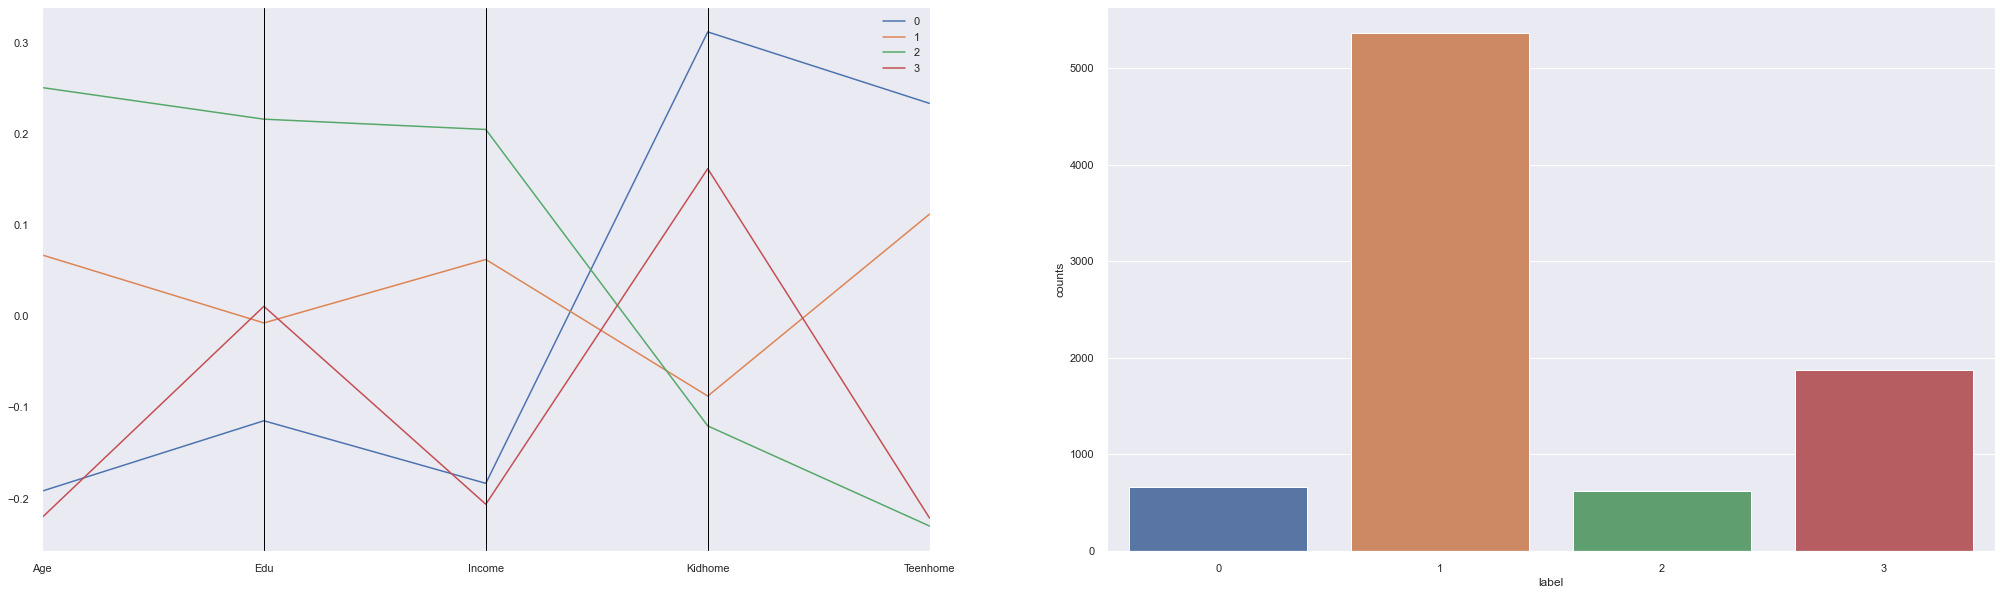

In [53]:
cluster_profiles(perspective_final_HC.drop('BMU',axis=1), ["label"], (35,10), compar_titles=None)

In [ ]:
#creating a csv file to afterwards import to the merging notebook.
perspective_final_HC.to_csv('Demo(HC+SOM).csv',sep=';',index=False)